In [17]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

# Stats model library
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# ISLP - 
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize , poly)

### Boston Data

- `crim`: per capita crime rate by town.
- `zn`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `indus` : proportion of non-retail business acres per town.
- `chas` : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- `nox` : nitrogen oxides concentration (parts per 10 million).
- `rm` : average number of rooms per dwelling.
- `age` : proportion of owner-occupied units built prior to 1940.
- `dis` : weighted mean of distances to five Boston employment centres.
- `rad` : index of accessibility to radial highways.
- `tax` : full-value property-tax rate per $10,000.
- `ptratio` : pupil-teacher ratio by town.
- `lstat` : lower status of the population (percent).
- `medv` : median value of owner-occupied homes in 1000s.

`np.ones()` : To create the numpy array of ones

In [20]:
boston = load_data("Boston")
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [42]:
# Preparing the data set
x_prep = {"intercept" : np.ones(boston.shape[0]), "lstat" : boston["lstat"]}
x = pd.DataFrame(x_prep)
y = boston["medv"] 

model = sm.OLS(y,x)
results = model.fit()
summarize(results) # Gets you the reduced summary

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


### Transforming the Dataset

#### Steps:
1. **Model Fitting and Transformation**
   - `ModelSpec()`:
     - `fit()` : Fits the model to the data.
     - `transform()` : Transforms the dataset.

2. **Access Model Parameters**
   - `results.params` to retrieve the fitted parameters.
   - `results.fittedvalues` : to retrieve the fitted values
   - `results.resid` : to retrieve the residual values

3. **Summary of Results**
   - `results.summary()` to display the summary statistics of the model.
   - `results.get_influence()` : to get the hat or the influence matrix

4. **Making Predictions**
   - `results.get_prediction(<data_set>)` to generate predictions for a dataset.

#### Confidence and Prediction Intervals
- **Confidence Intervals:**
  - Use `predictions.conf_int(alpha)` to calculate confidence intervals for predictions.
  
- **Prediction Intervals:**
  - Use `predictions.conf_int(alpha, obs=True)` to calculate prediction intervals.
 
#### Measuring goodness of fit
- `variance_inflation_factor()` : to know about the multicollinearity
- `anova_lm()` : to get the comparision between fits

In [53]:
design = MS(["lstat"])
design_fit = design.fit(boston)
design_trans = design_fit.transform(boston)

# Prediction
predd = pd.DataFrame({"lstat" : [5,10,15]})
pred = design_fit.transform(predd)
predictions = results.get_prediction(pred)

# To get the predicted mean
predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

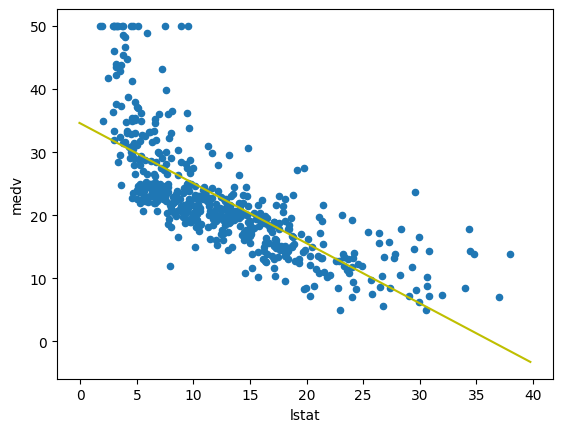

In [66]:
# Defining the function
def abline(ax, b, m, *args, **kwargs) : 
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = boston.plot.scatter('lstat', 'medv')
abline(ax, results.params.iloc[0], results.params.iloc[1], "y-")

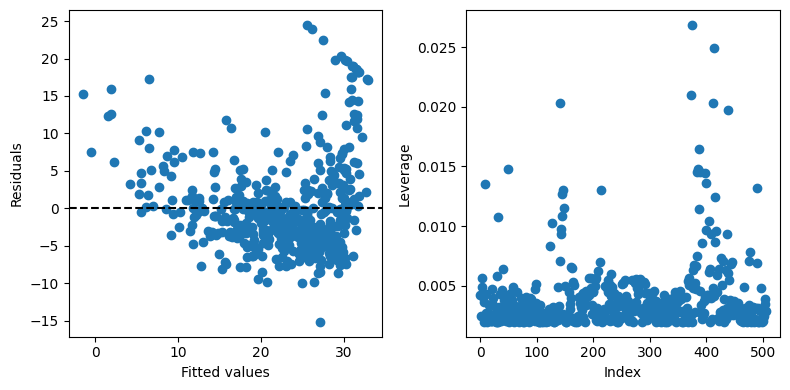

In [88]:
import matplotlib.pyplot as plt

# Some Diagnostic Plots

ax = plt.subplots(1,2,figsize = (8,4))[1]
ax[0].scatter(results.fittedvalues, results.resid)
ax[0].set_xlabel("Fitted values")
ax[0].set_ylabel("Residuals")
ax[0].axhline(0, c = "k", ls = "--") # For setting the horizontal line

infl = results.get_influence()
ax[1].scatter(np.arange(x.shape[0]), infl.hat_matrix_diag)
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Leverage")
np.argmax(infl.hat_matrix_diag) # To get the highest leverate statistics

plt.tight_layout()
plt.show()

In [94]:
# Mulitple linear regression
x = MS(['lstat', 'age']).fit_transform(boston)
model = sm.OLS(y,x).fit()
summarize(model)

# Fitting using every columns
terms = boston.columns.drop('medv')
x = MS(terms).fit_transform(boston)
model = sm.OLS(y,x).fit()
summarize(model) # Fitting everything

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [110]:
# Getting the variance inflation factor

vals = [VIF(x,i) for i in range(1, x.shape[1])] # Using list comprehension 
dat = pd.DataFrame({"VIF" : vals}, index = x.columns[1:]) # Setting the index as the columns

# Interaction terms
x = MS(['lstat', 'age', ("lstat", "age")]).fit_transform(boston)
model = sm.OLS(y,x).fit() # Always remember to fit the model
summarize(model)

# Non linear transformation
x = MS(["lstat", poly("lstat", degree = 2)]).fit_transform(boston)
model = sm.OLS(y,x).fit()
summarize(model) # Perfect fit ig?

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,coef,std err,t,P>|t|
intercept,34.3399,0.497,69.111,0.0
lstat,-0.9331,0.034,-27.279,0.0
"poly(lstat, degree=2)[0]",-2.7134,0.039,-68.933,0.0
"poly(lstat, degree=2)[1]",64.2272,5.524,11.628,0.0


In [250]:
# Qualitative predictors - similar to the quantitative predictors, not much difference
# Learn more about the encodings please

cars = load_data("Carseats")
allvars = cars.columns.drop("Sales") # Dropping sales
y = cars["Sales"]
x = MS(allvars).fit_transform(cars)
model = sm.OLS(y,x).fit()
summarize(model)

,coef,std err,t,P>|t|
intercept,5.6606,0.603,9.380,0.000
CompPrice,0.0928,0.004,22.378,0.000
Income,0.0158,0.002,8.565,0.000
Advertising,0.1231,0.011,11.066,0.000
Population,0.0002,0.000,0.561,0.575
Price,-0.0954,0.003,-35.700,0.000
ShelveLoc[Good],4.8502,0.153,31.678,0.000
ShelveLoc[Medium],1.9567,0.126,15.516,0.000
Age,-0.0460,0.003,-14.472,0.000
Education,-0.0211,0.020,-1.070,0.285


### Plot Creation

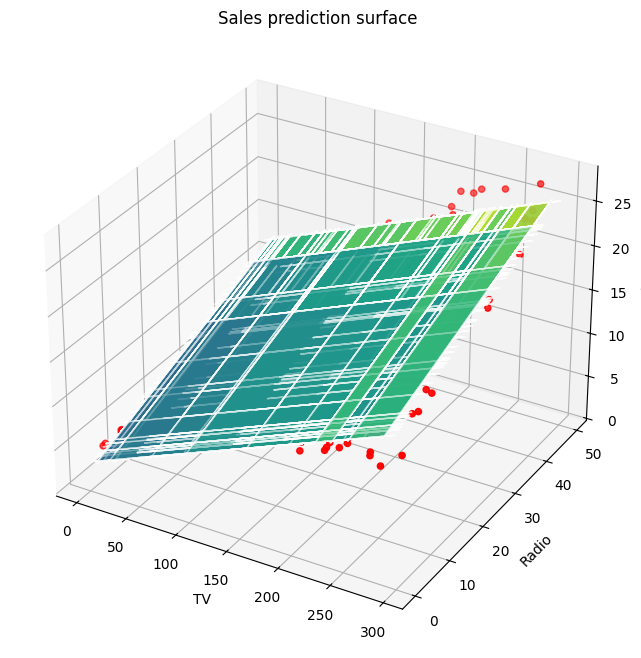

In [220]:
from mpl_toolkits.mplot3d import Axes3D

# Plotting the graphics 3.5
data = pd.read_csv("Data/Advertising.csv")

# Here we use the linear regression on sales ~ tv + radio 
y = data["sales"]
x = MS(["TV", "radio"]).fit_transform(data)
model = sm.OLS(y,x).fit()

# Creating a grid for data
tv = data["TV"]
radio = data["radio"]
tv, radio = np.meshgrid(tv, radio) # Very important for 3D
grid_df = pd.DataFrame({
    "intercept" : np.ones(tv.ravel().shape),
    "TV" : tv.ravel(),
    "radio" : radio.ravel() # ravel() flattens the nD array to 1D
})
predictions = model.predict(grid_df).values.reshape(tv.shape)

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize = (10,8))
ax.scatter(data['TV'], data['radio'], data['sales'], color='red', label='Data Points')
surf = ax.plot_surface(tv, radio, predictions, cmap='viridis', alpha=0.5, edgecolor='w')

ax.set_xlabel("TV")
ax.set_ylabel("Radio")
ax.set_zlabel("Sales")
ax.set_title("Sales prediction surface")
ax.view_init() # Elevation and Azim

plt.show()

In [243]:
# Plotting 3.6 - Credit Data
data = pd.read_csv("Data/Credit.csv")
cols = data.columns.drop(["Own", "Married", "Region", "Student"]).sort_values()
cols

Index(['Age', 'Balance', 'Cards', 'Education', 'Income', 'Limit', 'Rating'], dtype='object')

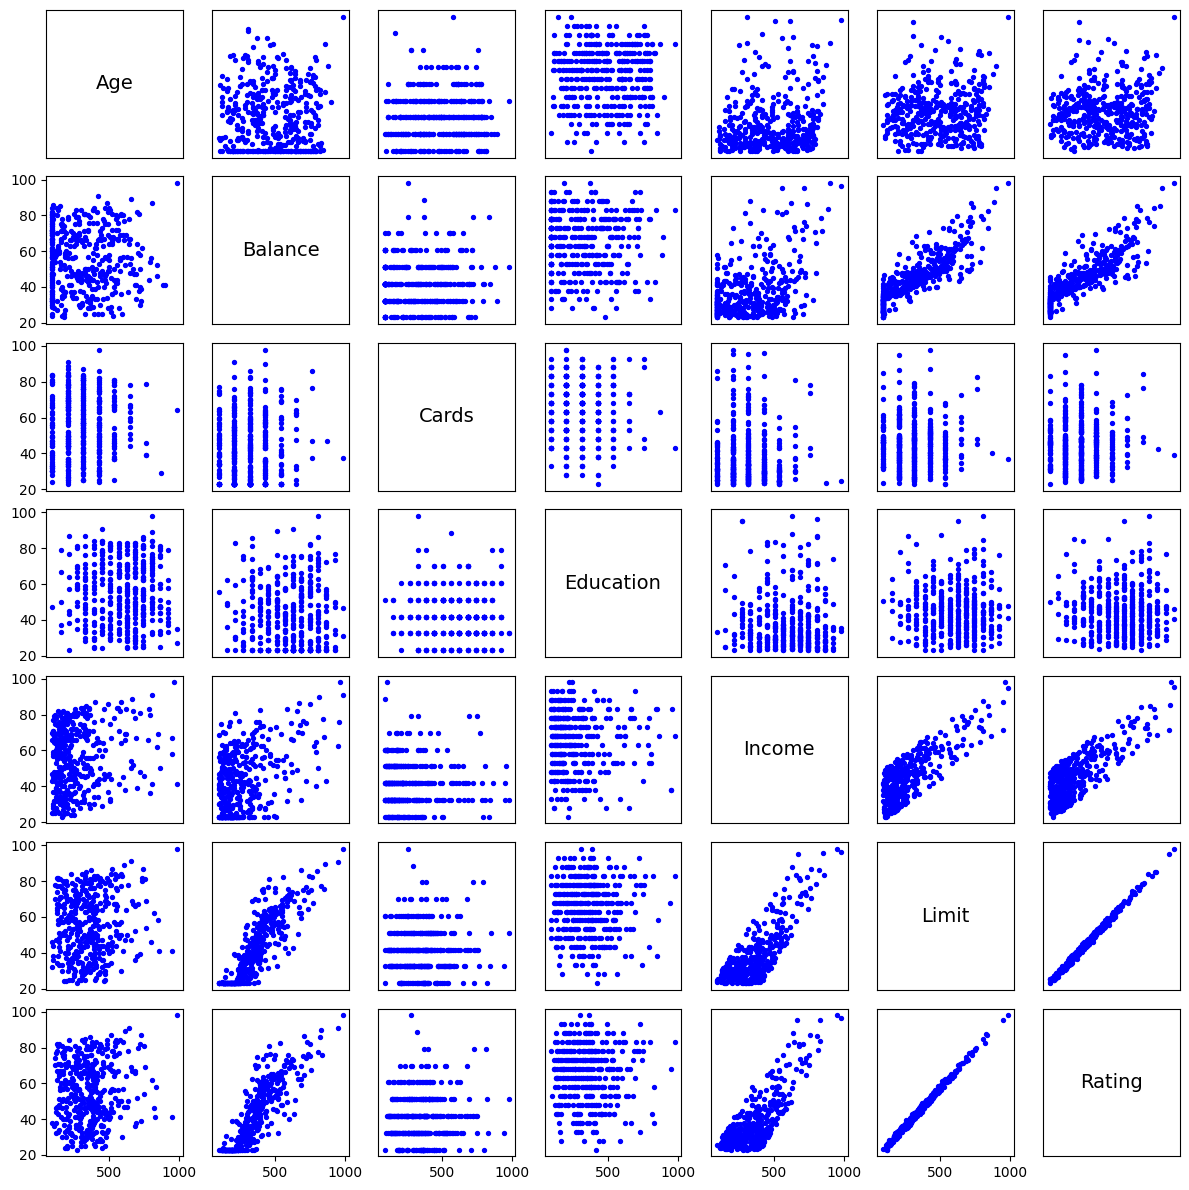

In [249]:
fig, axes = plt.subplots(len(cols), len(cols), figsize = (12,12))

# enumerate makes the indexing possible

for i, col1 in enumerate(cols) : 
    for j, col2 in enumerate(cols) : 
        ax = axes[i,j] 
        if i == j : 
            ax.text(0.5, 0.5, col1, ha='center', va='center', fontsize = 14)
            ax.set_xticks([])
            ax.set_yticks([])
        else : 
            ax.scatter(data[col1], data[col2], color = "blue", s = 8)
            
        if i != len(cols) - 1: # Current row is not the last row
            ax.set_xticks([])
        if j != 0: # Current columns is not the first column 
            ax.set_yticks([]) 

plt.tight_layout()
plt.show()